In [102]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import mord
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mord import LAD
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
with open('rev_2016_df.pkl', 'rb') as f:
    rev_train = pickle.load(f)
with open('rev_2017.pkl', 'rb') as f:
    rev_test = pickle.load(f)

In [9]:
rev_train['text_len'] = rev_train['text'].apply(lambda x: len(x.split()))

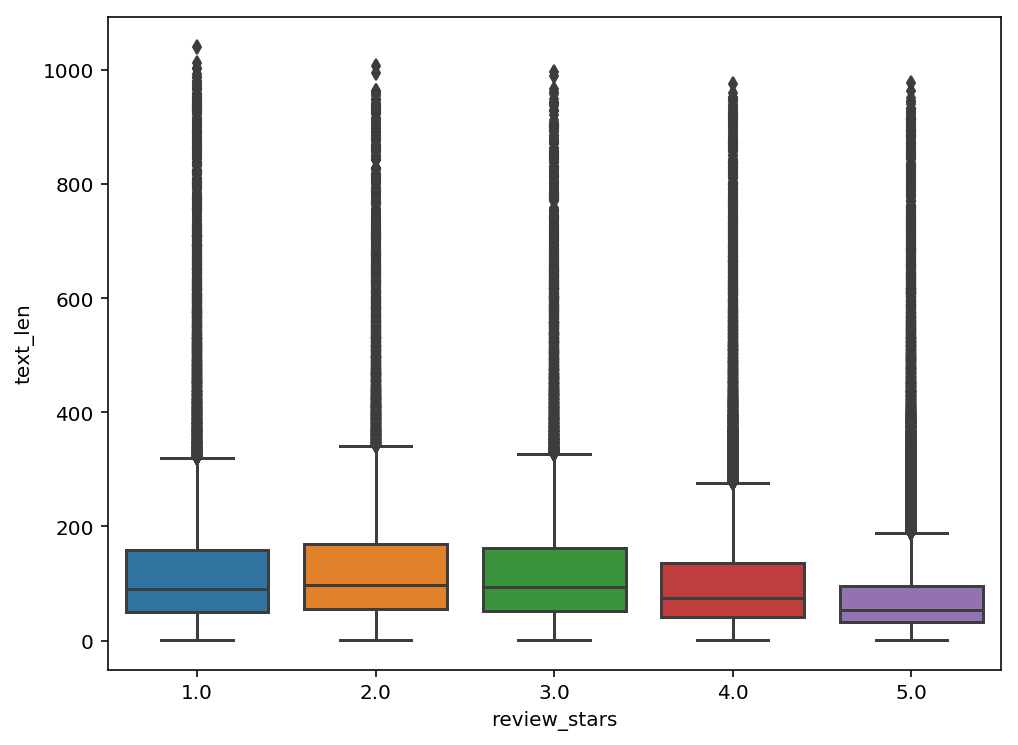

In [272]:
plt.figure(figsize=(8,6))
sns.boxplot(x = 'review_stars', y = 'text_len', data = rev_train)

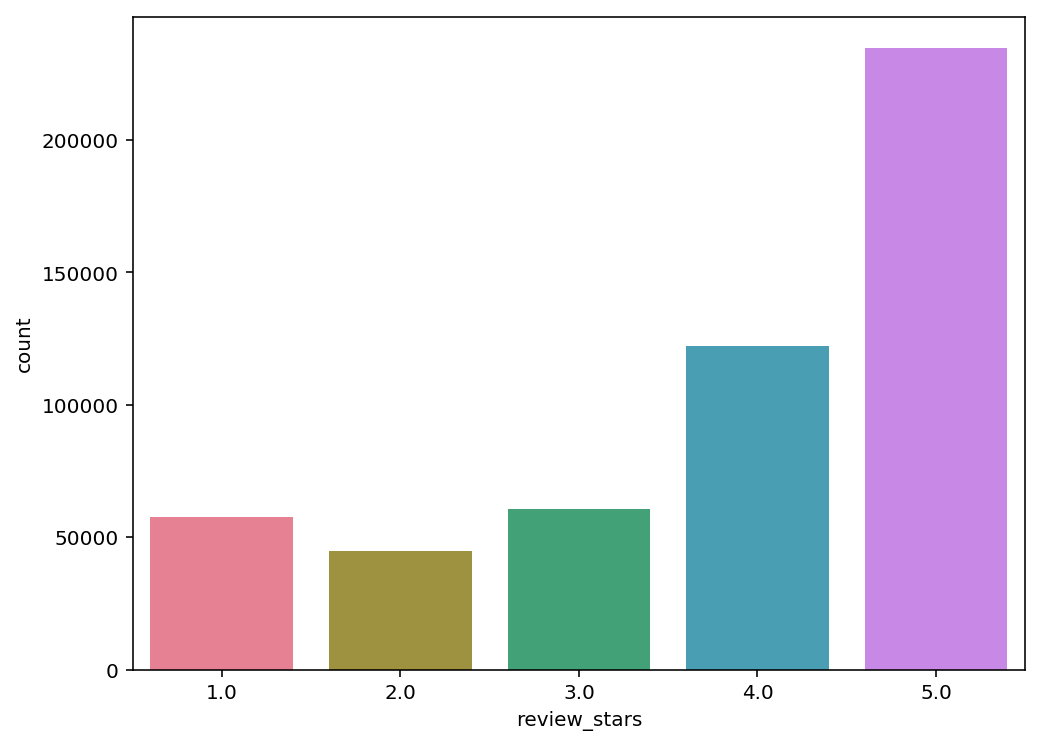

In [276]:
plt.figure(figsize=(8,6))
sns.countplot('review_stars', data = rev_train, palette="husl")

In [10]:
rev_train = rev_train[rev_train.review_stars != 3.0]

In [11]:
rev_train['target'] = rev_train.review_stars.apply(lambda x: 1 if x > 3 else 0)

In [12]:
print(len(rev_train))
mask = (rev_train['text'].str.len() > 50) & (rev_train['text'].str.len() < 200)
rev_train = rev_train.loc[mask]
print(len(rev_train))

459259
107918


In [13]:
rev_train.head()

,attributes,business_id,categories,city,name,biz_stars,state,date,review_stars,text,useful,real_counts,text_len,target
1250,"{'WiFi': 'u'no'', 'RestaurantsAttire': ''dress...",--9e1ONYQuAa-CB_Rrw7Tw,"Cajun/Creole, Seafood, Steakhouses, Restaurants",Las Vegas,Delmonico Steakhouse,4.0,NV,2016-01-04 20:50:22,5.0,Best Steak I ever eaten - Delmonico Rib Eye. I...,0,1661,19,1
1254,"{'WiFi': 'u'no'', 'RestaurantsAttire': ''dress...",--9e1ONYQuAa-CB_Rrw7Tw,"Cajun/Creole, Seafood, Steakhouses, Restaurants",Las Vegas,Delmonico Steakhouse,4.0,NV,2016-01-09 05:02:03,4.0,One of the better steaks I've had. Crispy on t...,0,1661,20,1
1268,"{'WiFi': 'u'no'', 'RestaurantsAttire': ''dress...",--9e1ONYQuAa-CB_Rrw7Tw,"Cajun/Creole, Seafood, Steakhouses, Restaurants",Las Vegas,Delmonico Steakhouse,4.0,NV,2016-02-10 17:16:11,5.0,Truly Fantastic! Best Steak ever. Service was...,0,1661,25,1
1285,"{'WiFi': 'u'no'', 'RestaurantsAttire': ''dress...",--9e1ONYQuAa-CB_Rrw7Tw,"Cajun/Creole, Seafood, Steakhouses, Restaurants",Las Vegas,Delmonico Steakhouse,4.0,NV,2016-03-21 20:35:34,5.0,This place is perfect. Love eating here. Its m...,0,1661,37,1
1286,"{'WiFi': 'u'no'', 'RestaurantsAttire': ''dress...",--9e1ONYQuAa-CB_Rrw7Tw,"Cajun/Creole, Seafood, Steakhouses, Restaurants",Las Vegas,Delmonico Steakhouse,4.0,NV,2016-03-21 20:45:39,5.0,The Japanese Wagyu steak is so tender...it mel...,0,1661,32,1


In [314]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['come','order','try','go','get','make','drink','plate','dish','restaurant','place',
                  'would','really','like','great','service','came','got'])

In [315]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [316]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [317]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [261]:
# def lemmatization(texts, allowed_postags=['NOUN','ADV']):
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

In [318]:
def get_corpus(df):
    """
    DOCSTRING
    """
    
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [362]:
bigram_train4[0]

['best',
 'steak',
 'ever_eaten',
 'delmonico',
 'rib_eye',
 'pricey_worth',
 'disappointed']

In [319]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(rev_train)

In [320]:
with open('train_corpus4.pkl', 'wb') as f:
    pickle.dump(train_corpus4, f)
with open('train_id2word4.pkl', 'wb') as f:
    pickle.dump(train_id2word4, f)
with open('bigram_train4.pkl', 'wb') as f:
    pickle.dump(bigram_train4, f)
# with open('lemma_train.pkl', 'wb') as f:
#     pickle.dump(lemma_train, f)

In [88]:
# make sure importing right model
lda_train4 = gensim.models.ldamulticore.LdaMulticore.load('lda_train4.model')

In [89]:
with open('train_corpus4.pkl', 'rb') as f:
    train_corpus4 = pickle.load(f)
with open('train_id2word4.pkl', 'rb') as f:
    train_id2word4 = pickle.load(f)
with open('bigram_train4.pkl', 'rb') as f:
    bigram_train4 = pickle.load(f)
# with open('lemma_train.pkl', 'rb') as f:
#     lemma_train = pickle.load(f)

In [321]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=20,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train4.save('lda_train4.model')

In [90]:
coherence_model_lda = CoherenceModel(model=lda_train4, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.28968209563844455

In [91]:
lda_train4.print_topics(20,num_words=15)[:3]

[(0,
  '0.042*"could" + 0.033*"ok" + 0.032*"stars" + 0.026*"open" + 0.025*"healthy" + 0.015*"simple" + 0.013*"want" + 0.012*"packed" + 0.012*"makes" + 0.012*"ingredients" + 0.012*"option" + 0.012*"choice" + 0.011*"french_toast" + 0.011*"offer" + 0.011*"literally"'),
 (1,
  '0.044*"take" + 0.038*"places" + 0.028*"table" + 0.023*"pork" + 0.023*"one" + 0.019*"one_favorite" + 0.017*"business" + 0.016*"even_better" + 0.016*"close" + 0.015*"minutes" + 0.013*"neighborhood" + 0.013*"wrong" + 0.013*"waiting" + 0.012*"cute" + 0.011*"never"'),
 (2,
  '0.074*"chicken" + 0.053*"good" + 0.028*"ordered" + 0.028*"salad" + 0.026*"delicious" + 0.024*"pho" + 0.023*"thai" + 0.021*"spicy" + 0.021*"soup" + 0.020*"shrimp" + 0.020*"beef" + 0.017*"fresh" + 0.016*"rice" + 0.016*"tasty" + 0.015*"also"')]

## Make Vectors

In [92]:
train_vecs = []
for i in range(len(rev_train)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([rev_train.iloc[i].real_counts]) # counts of reviews for restaurant
    topic_vec.extend([len(rev_train.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [93]:
train_vecs[2]

[0.0033333334,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.1025259,
 0.0033333334,
 0.0033333334,
 0.51653683,
 0.1439744,
 0.0033333336,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.0033333334,
 0.18362956,
 1661,
 152]

In [94]:
X = np.array(train_vecs)

In [95]:
y = np.array(rev_train.target)

In [108]:
with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)

In [109]:
with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)

In [101]:
# np.count_nonzero(np.isinf(X))

107918

In [43]:
# X = X.astype(np.float128)
# y = y.astype(np.float128)

#### Performance absolutely terrible with balanced class weights, implying imbalanced less of a problem than just predicting actual stars. Need to move to yes/no groupings.

In [ ]:
kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
    
    # Logistic Regression Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='binary'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='binary'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_auc):.3f} +- {np.std(cv_lr_auc):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_auc):.3f} +- {np.std(cv_lrsgd_auc):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')

## Scratchpad Model Testing

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ss = StandardScaler()
X_tr_scale = ss.fit_transform(X_train)
X_te_scale = ss.transform(X_test)

mul_lr = LogisticRegression(
#   multi_class='multinomial',
  class_weight= 'balanced',
  solver='newton-cg',
  fit_intercept=True
  ).fit(X_tr_scale, y_train)

y_pred = mul_lr.predict(X_te_scale)
f1_score(y_test, y_pred, average='weighted')


0.8193696269066724

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ss = StandardScaler()
X_tr_scale = ss.fit_transform(X_train)
X_te_scale = ss.transform(X_test)

clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3,loss='hinge',class_weight='balanced')
clf.fit(X_tr_scale,y_train)

y_pred = clf.predict(X_te_scale)
f1_score(y_test, y_pred)

0.8472315117771471

In [100]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ss = StandardScaler()
X_tr_scale = ss.fit_transform(X_train)
X_te_scale = ss.transform(X_test)

svm = SVC(kernel='rbf', class_weight='balanced',cache_size=1000)
svm.fit(X_tr_scale, y_train)
y_pred_svm = svm.predict(X_te_scale)
f1_score(y_test, y_pred_svm, average='weighted')

0.8304260383315732

In [340]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
rfc = RandomForestClassifier(n_estimators=128)
ss = StandardScaler()
X_tr_scale = ss.fit_transform(X_train)
X_te_scale = ss.transform(X_test)

rfc.fit(X_tr_scale, y_train)

y_pred_rfc = rfc.predict(X_te_scale)
f1_score(y_test, y_pred_rfc,average='weighted')

0.8788715806566277

In [231]:
import xgboost as xgb
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xg = XGBClassifier(objective='binary:logistic', nthread=7)

ss = StandardScaler()
X_tr_scale = ss.fit_transform(X_train)
X_te_scale = ss.transform(X_test)

xg.fit(X_tr_scale, y_train)
y_pred_xg = xg.predict(X_te_scale)
f1_score(y_test, y_pred_xg)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:231: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


0.6239741552249694

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = MultinomialNB()
ss = MinMaxScaler()
X_tr_scale = ss.fit_transform(X_train)
X_te_scale = ss.transform(X_test)
clf.fit(X_tr_scale, y_train)
y_pred = clf.predict(X_te_scale)
f1_score(y_test, y_pred)

0.5978949013886355